In [10]:
import tensorflow as tf
import numpy as np

In [13]:
NUM_CLASSES = 10
WIDTH = 32
NUM_CHANNELS = 3
NUM_TRAIN = 50000
NUM_TEST = 10000
NUM_DEV = 100

DATASET = "cifar10"
BASE_DIR = ""  # set to whatever directory you are working/saving in
BATCH_SIZE = 128  # increase batch_size for faster training (if your file does not crash)

## Data loading

In [14]:
def _normalize(X):
  assert X.dtype == np.uint8
  X = X.astype(np.float64)
  X /= 255
  return X

def get_one_hot(targets, nb_classes):
  res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
  return res.reshape(list(targets.shape)+[nb_classes])

def load_standard_cifar10():
  (X_train, Y_train), (X_validation, Y_validation) = tf.keras.datasets.cifar10.load_data()
  X_train = X_train.reshape(X_train.shape[0], WIDTH, WIDTH, NUM_CHANNELS)
  X_validation = X_validation.reshape(X_validation.shape[0], WIDTH, WIDTH, NUM_CHANNELS)

  X_train = _normalize(X_train)
  X_validation = _normalize(X_validation)

  Y_train = Y_train.astype(np.int32)
  Y_validation = Y_validation.astype(np.int32)

  return X_train, Y_train, X_validation, Y_validation

def load_cifar10_train_dev(num_dev=100):
  # randomly select and fixed for future (tracin-like strategy but their indices available only for mnist)
  selected_dev = [5214, 2304, 5947, 9428, 2717, 8296, 7736, 8291, 5235, 54,
                  7499, 9590, 3675, 1932, 6646, 8719, 6484, 6306, 3066, 2442,
                  6106, 1949, 4320,  541, 1318, 5967, 2773, 3847, 1152, 9937,
                  7469, 5982, 7644, 5820, 8152, 9518,  601, 3953, 4931, 1924,
                  5342, 5467, 6718, 6779, 2860, 2440, 5480, 1178,  222, 7909,
                  6394, 3511, 8729, 6261, 7192, 9453, 5257, 9077, 6419, 3280,
                  3725, 3601, 8174, 5703, 4954, 9536, 4783, 2234, 7365, 2405,
                  3073, 2780, 7461, 3525, 7573, 6764, 9962, 7527,  992,  315,
                  6260, 9061,  592, 8003, 7594, 1930, 7215, 5124, 7531, 9471,
                  2824, 3533, 6062, 3946, 5246, 4440,  414, 3572, 4899, 884]
  X_train, Y_train, X_validation, Y_validation = load_standard_cifar10()
  # selected_dev = np.random.randint(0, X_validation.shape[0], num_dev)
  X_dev = X_validation[selected_dev]
  Y_dev = Y_validation[selected_dev]
  return X_train, Y_train, X_dev, Y_dev

In [15]:
X_train, Y_train, X_test, Y_test = load_standard_cifar10()
_, _, X_dev, Y_dev = load_cifar10_train_dev()

In [16]:
Y_train = np.squeeze(np.array(Y_train))
Y_test = np.squeeze(np.array(Y_test))
Y_dev = np.squeeze(np.array(Y_dev))

In [17]:
print(X_train.shape, X_test.shape, X_dev.shape, Y_train.shape, Y_test.shape, Y_dev.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3) (100, 32, 32, 3) (50000,) (10000,) (100,)


### Model loading

In [97]:
trained_epochs = 100
base_dnn = 'resnet50'

MODEL_DIR = f"{BASE_DIR}/{DATASET}_{base_dnn}_{trained_epochs}e.h5"
model = tf.keras.models.load_model(MODEL_DIR)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_3 (UpSamplin  (None, 224, 224, 3)       0         
 g2D)                                                            
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 160)               327840    
                                                                 
 batch_normalization_3 (Bat  (None, 160)              

### Getting hidden outputs

In [98]:
features_input = tf.keras.Input(shape=(WIDTH, WIDTH, NUM_CHANNELS))
labels_input = tf.keras.Input(shape=(NUM_CLASSES,))

In [99]:
h_x = features_input
for layer_num in range(len(model.layers) - 2):
  h_x = model.layers[layer_num](h_x, training=False)
last_layer_model = tf.keras.Model(inputs=features_input, outputs=h_x)
last_layer_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_3 (UpSamplin  (None, 224, 224, 3)       0         
 g2D)                                                            
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 160)               3278

In [100]:
X_hidden_outputs = last_layer_model.predict(X_train)
X_hidden_outputs.shape

1563/1563 [==============================] - 44s 27ms/step


(50000, 160)

In [101]:
P_train = model.predict(X_train)
P_test = model.predict(X_test)

313/313 [==============================] - 10s 32ms/step


In [102]:
print(f"Accuracy (Train): {(P_train.argmax(axis=1) == np.squeeze(Y_train)).mean()}")
print(f"Accuracy (Test): {(P_test.argmax(axis=1) == np.squeeze(Y_test)).mean()}")

Accuracy (Train): 0.99852
Accuracy (Test): 0.9328


### Representer

In [103]:
import time

In [104]:
class Linear(tf.keras.Model):
  def __init__(self, num_classes):
    super(Linear, self).__init__()
    self.fc = tf.keras.layers.Dense(
        num_classes,
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01))

  def call(self, inputs):
    return self.fc(inputs)

def run():
  ###############################################
  start_time = int(time.time())

  num_train_examples = NUM_TRAIN
  tensorboard_summary_dir = (f"{BASE_DIR}/tmp/{DATASET}/original/representer/{start_time}/tensorboard/")
  checkpoint_dir = (f"{BASE_DIR}/tmp/{DATASET}/original/representer/{start_time}/checkpoint/")

  epochs = 100
  lr = 1.0
  num_classes = NUM_CLASSES
  ###################
  train_batch_size = 50000
  # train_batch_size = 60000
  # strategy_str = "one_gpu"
  # tpu_address = "v3-8"
  lam = 0.001
  checkpoint_frequency = 250
  ###############################################
  # strategy = get_strategy(strategy_str, tpu_address=tpu_address)
  # if train_batch_size % strategy.num_replicas_in_sync != 0:
  #   raise ValueError(
  #       'Train batch size must be divisible by number of replicas : {}'.format(
  #           strategy.num_replicas_in_sync))
  train_steps_per_epoch = num_train_examples // train_batch_size


  BATCH_SIZE = 200
  train_ds = tf.data.Dataset.from_tensor_slices((tf.cast(X_hidden_outputs, dtype=tf.float32), P_train)).take(num_train_examples).batch(BATCH_SIZE, drop_remainder=True)


  final_layer = Linear(num_classes)
  optim = tf.keras.optimizers.SGD(learning_rate=lr)

  train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
  train_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(
      1, 'train_accuracy', dtype=tf.float32)
  grad_norm = tf.keras.metrics.Mean('grad_norm', dtype=tf.float32)

  final_layer_checkpoint = tf.train.Checkpoint(model=final_layer)

  train_iter = iter(train_ds)

  @tf.function
  def train_step(inputs):
    hidden_outputs, probs = inputs
    with tf.GradientTape() as tape:
      logits = final_layer(hidden_outputs)
      loss = tf.keras.losses.categorical_crossentropy(
          probs, logits, from_logits=True)
      loss = tf.reduce_mean(loss)

      l2_loss = lam * tf.add_n([
          tf.nn.l2_loss(v)
          for v in final_layer.trainable_weights])
      loss += l2_loss

    grads = tape.gradient(loss, final_layer.trainable_weights)
    g_norm = tf.norm(tf.concat([grads[0],
        tf.expand_dims(grads[1], axis=0)], axis=0))
    beta = tf.constant(0.5)
    t = tf.constant(10.0)

    while tf.constant(True):
      new_logits = tf.matmul(hidden_outputs, (final_layer.trainable_weights[0]-t*grads[0])) + (
          (final_layer.trainable_weights[1]-t*grads[1]))
      new_loss = tf.keras.losses.categorical_crossentropy(
          probs, new_logits, from_logits=True)
      new_loss = tf.reduce_mean(new_loss)
      new_l2_loss = lam * tf.add_n([
          tf.nn.l2_loss(v-t*g)
          for g, v in zip(grads, final_layer.trainable_weights)])
      new_loss += new_l2_loss
      if tf.less_equal(new_loss - loss + t * g_norm *  g_norm * 0.5, 0):
        break
      t *= beta
      if tf.less(t, 0.0000000001):
        t *= 0.0
        break
    optim.apply_gradients(zip([t * grad for grad in grads], final_layer.trainable_weights))


    train_loss.update_state(loss)
    grad_norm.update_state(g_norm)
    train_accuracy.update_state(probs, logits)

  for epoch in range(1, epochs + 1):
    train_loss.reset_states()
    train_accuracy.reset_states()
    grad_norm.reset_states()
    train_steps_in_current_epoch = 0
    for inputs in train_ds:
      train_step(inputs)
      steps = min(train_steps_per_epoch,
                  train_steps_per_epoch - train_steps_in_current_epoch)

      train_steps_in_current_epoch += steps

    print('Done training epoch %s' % (epoch))
    print('train_loss %f' % (train_loss.result()))
    print('train_accuracy %f' % (train_accuracy.result()))
    print('grad_norm %f' % (grad_norm.result()))

    # Save checkpoint
    if epoch % checkpoint_frequency == 0:
      checkpoint_name = final_layer_checkpoint.save(
          os.path.join(checkpoint_dir,
              'model-{epoch:04d}.ckpt'.format(epoch=epoch)))
      print('Saved checkpoint to %s', checkpoint_name)
    print('==================================================')

    current_steps = epoch * train_steps_per_epoch
  return final_layer

final_layer = run()

Done training epoch 1
train_loss 0.096312
train_accuracy 0.986540
grad_norm 0.808055
Done training epoch 2
train_loss 0.018387
train_accuracy 0.997440
grad_norm 0.242570
Done training epoch 3
train_loss 0.014919
train_accuracy 0.998040
grad_norm 0.181832
Done training epoch 4
train_loss 0.013629
train_accuracy 0.998420
grad_norm 0.152934
Done training epoch 5
train_loss 0.012994
train_accuracy 0.998600
grad_norm 0.135445
Done training epoch 6
train_loss 0.012628
train_accuracy 0.998700
grad_norm 0.123148
Done training epoch 7
train_loss 0.012409
train_accuracy 0.998760
grad_norm 0.114966
Done training epoch 8
train_loss 0.012232
train_accuracy 0.998940
grad_norm 0.107109
Done training epoch 9
train_loss 0.012137
train_accuracy 0.999000
grad_norm 0.102714
Done training epoch 10
train_loss 0.012029
train_accuracy 0.999020
grad_norm 0.097495
Done training epoch 11
train_loss 0.011988
train_accuracy 0.999080
grad_norm 0.095367
Done training epoch 12
train_loss 0.011954
train_accuracy 0.999

In [105]:
def get_one_hot(targets, nb_classes):
  res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
  return res.reshape(list(targets.shape)+[nb_classes])

In [106]:
### want to work with entire test data as dev set for exemplar effect illustration
X_dev = X_test
Y_dev = Y_test

In [107]:
Y_dev_one_hot = get_one_hot(Y_dev, NUM_CLASSES)
Y_train_one_hot = get_one_hot(Y_train, NUM_CLASSES)

Y_train_one_hot = np.squeeze(Y_train_one_hot)
Y_dev_one_hot = np.squeeze(Y_dev_one_hot)

In [108]:
probs = tf.nn.softmax(final_layer(X_hidden_outputs))
weight_matrix = probs-Y_train_one_hot

X_dev_hidden_outputs = last_layer_model.predict(X_dev)

val_feature = X_dev_hidden_outputs
train_feature = X_hidden_outputs

val_feature_n = (val_feature.T / np.linalg.norm(val_feature, axis=1)).T
train_feature_n = (train_feature.T / np.linalg.norm(train_feature, axis=1)).T

alpha_js = []
representer_vals = []
sim_vals, sim_vals_normalized = [], []
for test_point in range(X_dev.shape[0]):
  target_class = np.squeeze(Y_dev[test_point])
  alpha_j = weight_matrix[:, target_class]
  sim_val = np.sum(train_feature * val_feature[test_point,:], axis=1)
  sim_val_normalized = np.sum(train_feature_n * val_feature_n[test_point,:], axis=1)
  representer_val = alpha_j * np.sum(train_feature * val_feature[test_point,:], axis=1)

  alpha_js.append(alpha_j)
  representer_vals.append(-1*representer_val)
  sim_vals.append(sim_val)
  sim_vals_normalized.append(sim_val_normalized)

np.save(f"{BASE_DIR}/{DATASET}_{base_dnn}_alpha_{trained_epochs}e.npy", weight_matrix, allow_pickle=True)
np.save(f"{BASE_DIR}/{DATASET}_{base_dnn}_alpha_j_{trained_epochs}e.npy", alpha_js, allow_pickle=True)
np.save(f"{BASE_DIR}/{DATASET}_{base_dnn}_representer_val_{trained_epochs}e.npy", representer_vals, allow_pickle=True)
np.save(f"{BASE_DIR}/{DATASET}_{base_dnn}_similarity_{trained_epochs}e.npy", sim_vals, allow_pickle=True)
np.save(f"{BASE_DIR}/{DATASET}_{base_dnn}_similarity_normalized_{trained_epochs}e.npy", sim_vals_normalized, allow_pickle=True)

313/313 [==============================] - 9s 27ms/step


## Analysis

In [17]:
trained_epochs = 10
base_dnn = 'resnet50'

inf = np.load(f"{BASE_DIR}/{DATASET}_{base_dnn}_representer_val_{trained_epochs}e.npy", allow_pickle=True)
model = tf.keras.models.load_model(f"{BASE_DIR}/{DATASET}_{base_dnn}_{trained_epochs}e.h5")

2024-02-02 18:22:15.785768: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14605 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [18]:
inf = -1*inf

In [19]:
n_top = 1

ix_top_list = []
for j in range(inf.shape[0]):
  inf_j = inf[j].copy()
  get_largest = False  # need get smallest perhaps because influence is -1*rep_val
  if get_largest:
    ix_top = np.argpartition(inf_j, -n_top)[-n_top:]
  else:
    ix_top = np.argpartition(inf_j, n_top-1)[:n_top]

  ix_top_list.append(ix_top)

ix_top_list = np.array(ix_top_list)

In [20]:
np.unique(Y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

In [21]:
thresh = 900
# thresh = 1000

val_counts = {v:c for v, c in zip(*np.unique(ix_top_list, return_counts=True)) if c>=thresh}
print(len(val_counts))
# val_counts

1


2024-02-02 18:22:31.361015: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902


1/1 [==============================] - 10s 10s/step


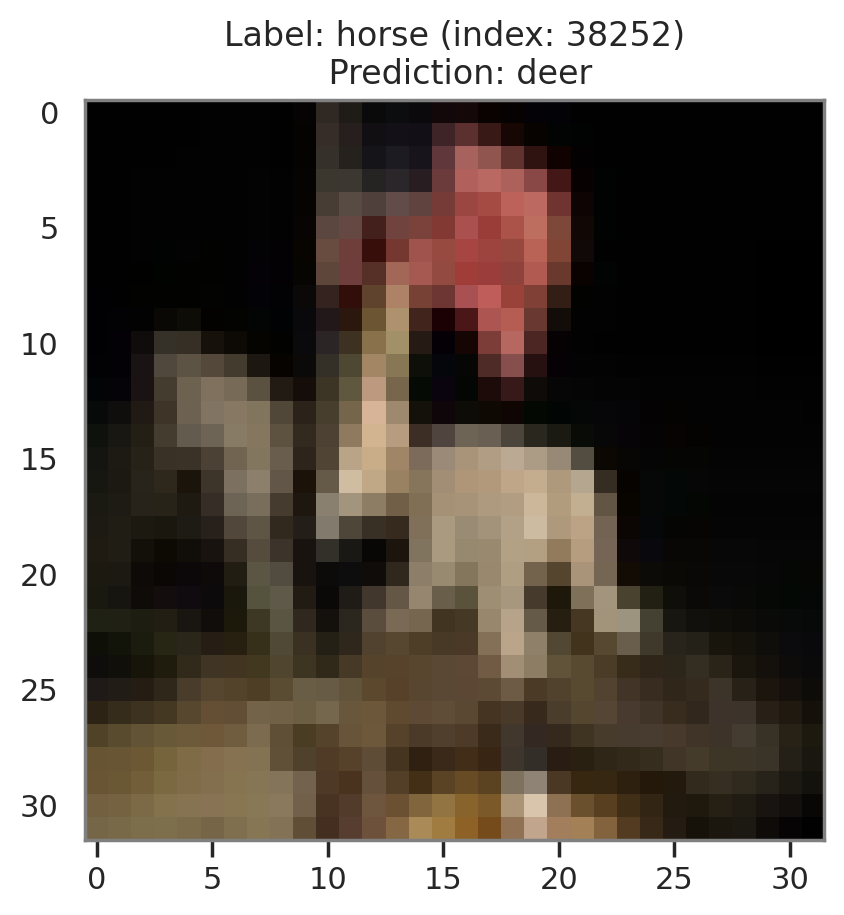

In [22]:
import matplotlib.pyplot as plt
label_dict = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

tr_ix_influential = list(val_counts.keys())
for i in tr_ix_influential:
  plt.figure()
  plt.imshow(X_train[i])
  plt.title(f"Label: {label_dict[Y_train[i]]} (index: {i})\n Prediction: {label_dict[np.argmax(model.predict(X_train[i][np.newaxis,:]))]}")

## Visualization

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
rcParams_ticks = {'figure.dpi': 200.0, 'xtick.bottom': True, 'ytick.left': False, 'legend.loc': 'lower right', 'legend.fancybox': True,
                  'axes.edgecolor': 'grey', 'axes.xmargin': 0.05, 'text.usetex': False}
sns.set_theme(style='ticks', rc=rcParams_ticks)

In [12]:
trained_epochs = 100
base_dnn = 'resnet50'

alpha = np.load(f"{BASE_DIR}/{DATASET}_{base_dnn}_alpha_{trained_epochs}e.npy", allow_pickle=True)
alpha_js = np.load(f"{BASE_DIR}/{DATASET}_{base_dnn}_alpha_j_{trained_epochs}e.npy", allow_pickle=True)
representer_vals = np.load(f"{BASE_DIR}/{DATASET}_{base_dnn}_representer_val_{trained_epochs}e.npy", allow_pickle=True)
sim_vals = np.load(f"{BASE_DIR}/{DATASET}_{base_dnn}_similarity_{trained_epochs}e.npy", allow_pickle=True)
sim_norm_vals = np.load(f"{BASE_DIR}/{DATASET}_{base_dnn}_similarity_normalized_{trained_epochs}e.npy", allow_pickle=True)

In [13]:
alpha_js.shape  # num_test x num_train
sparsity_thresh = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.9]
num_total = np.prod(alpha_js.shape)
for t in sparsity_thresh:
    num_gt_t = (np.abs(alpha_js) > t).sum()
    pct_gt_t = (num_gt_t / num_total) * 100
    pct_lt_t = 100 - pct_gt_t
    print(f"{pct_lt_t} percent of is almost 0 (<={t})")
    
# A CDF plot can be helpful visualization then!
# Different CDF for model trained for different epochs
# but threshold values very low

90.1622 percent of is almost 0 (<=1e-05)
94.7484 percent of is almost 0 (<=0.0001)
97.7882 percent of is almost 0 (<=0.001)
99.4098 percent of is almost 0 (<=0.01)
99.9218 percent of is almost 0 (<=0.1)
99.9928 percent of is almost 0 (<=0.5)
100.0 percent of is almost 0 (<=0.9)


In [14]:
for t in sparsity_thresh:
    num_gt_t = (np.abs(alpha_js) > t).sum()
    pct_gt_t = (num_gt_t / num_total) * 100
    print(f"{pct_gt_t} percent of training instances are influential (Grad>{t})")

9.8378 percent of training instances are influential (Grad>1e-05)
5.2516 percent of training instances are influential (Grad>0.0001)
2.2117999999999998 percent of training instances are influential (Grad>0.001)
0.5902000000000001 percent of training instances are influential (Grad>0.01)
0.0782 percent of training instances are influential (Grad>0.1)
0.0072 percent of training instances are influential (Grad>0.5)
0.0 percent of training instances are influential (Grad>0.9)


In [24]:
assert alpha_js.shape[0] == X_dev.shape[0]

X_dev = X_test.copy()
Y_dev = Y_test.copy()

7
21
26
39
87


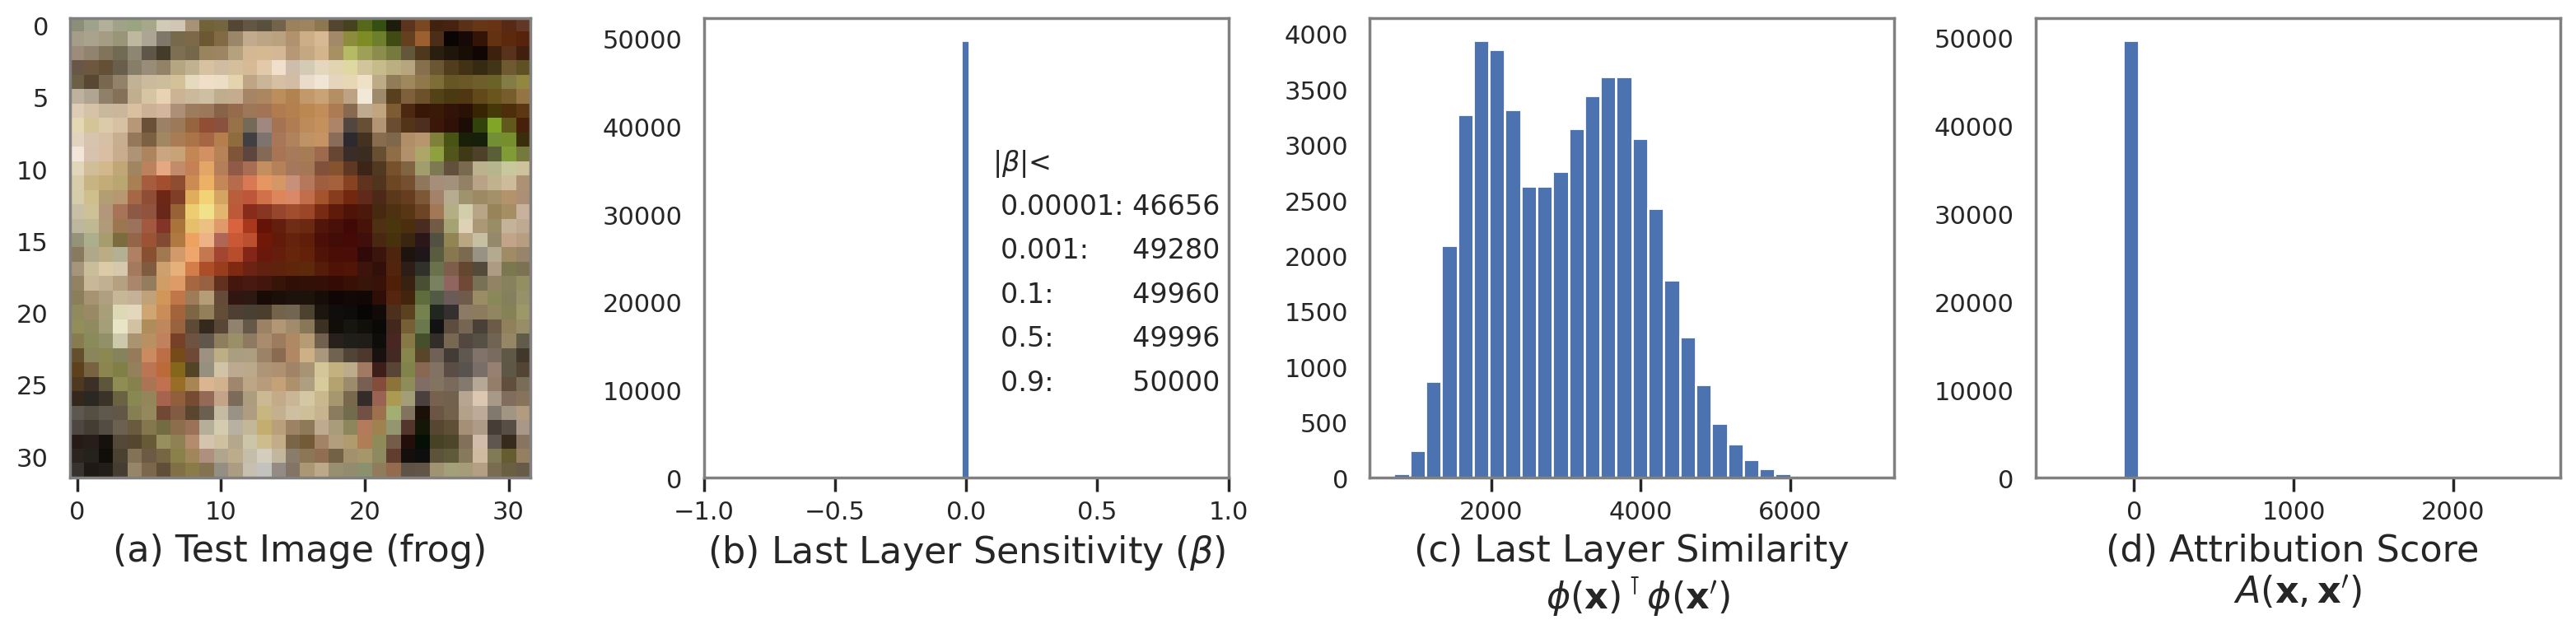

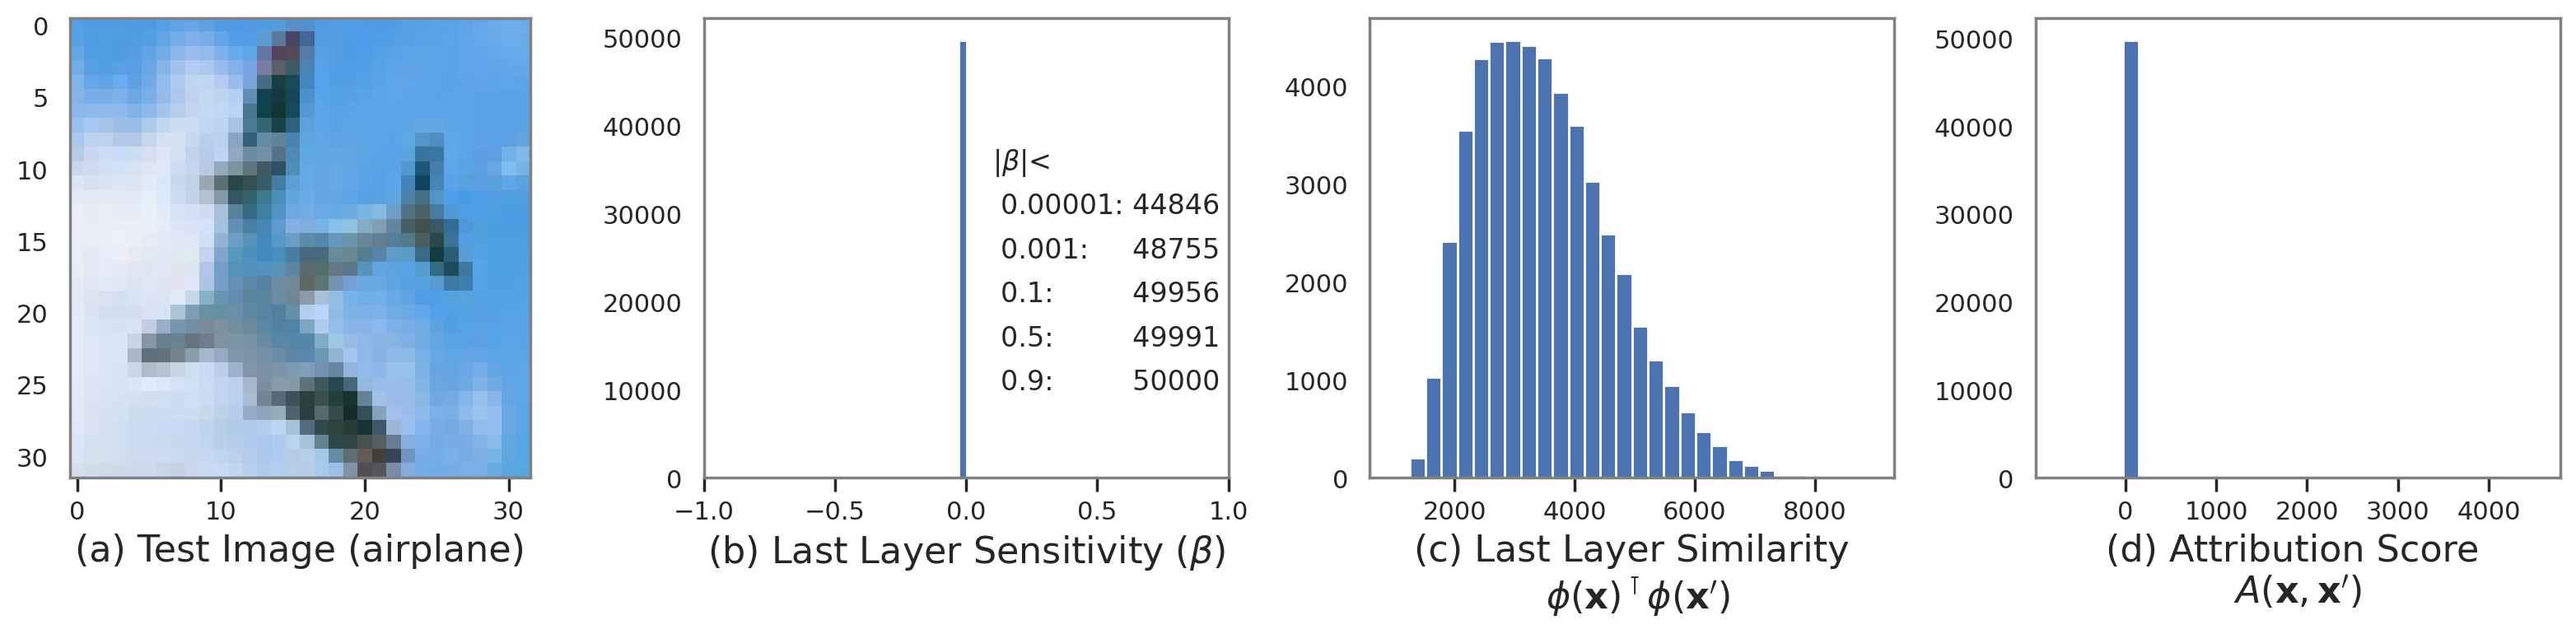

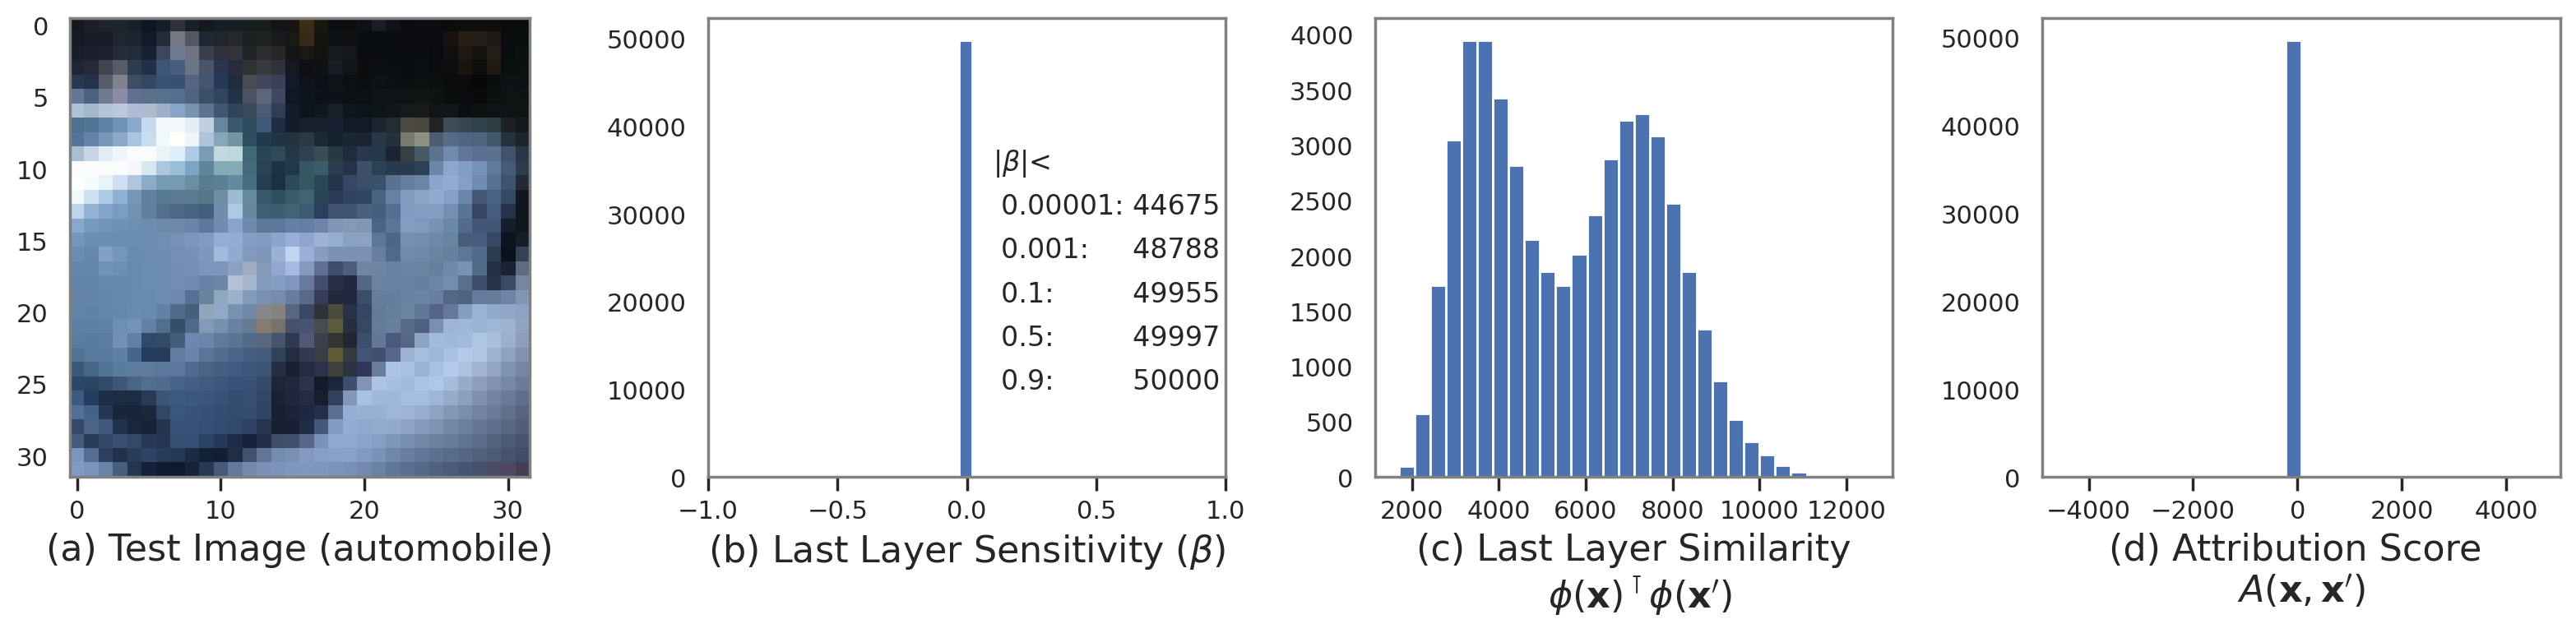

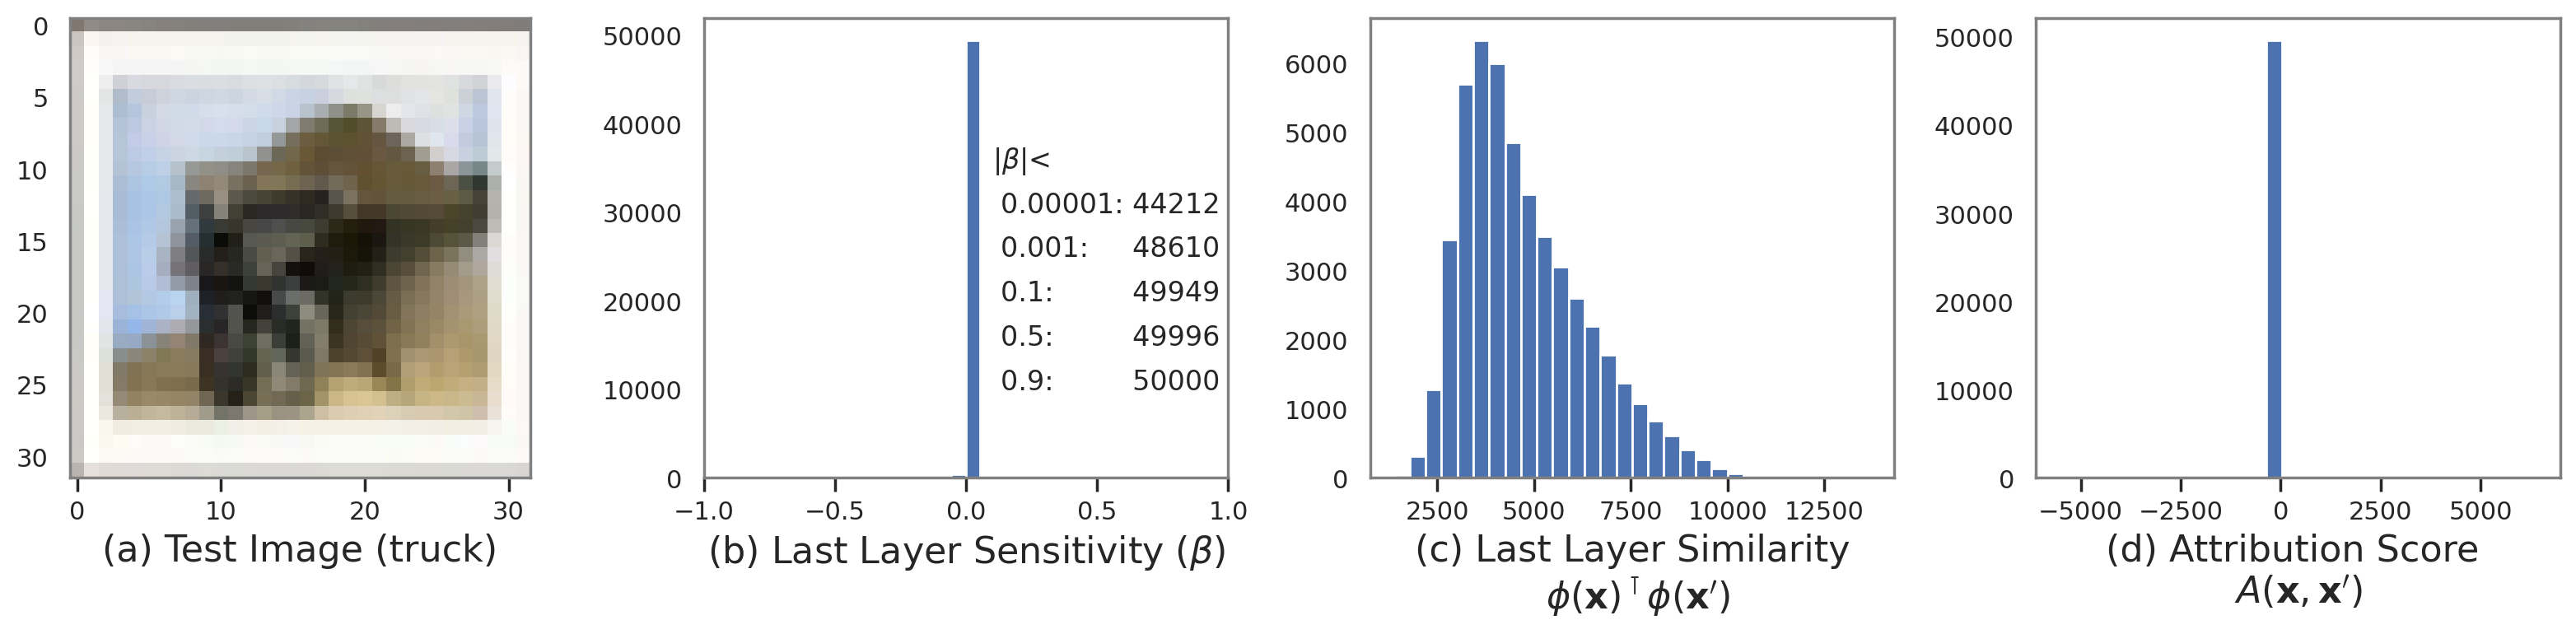

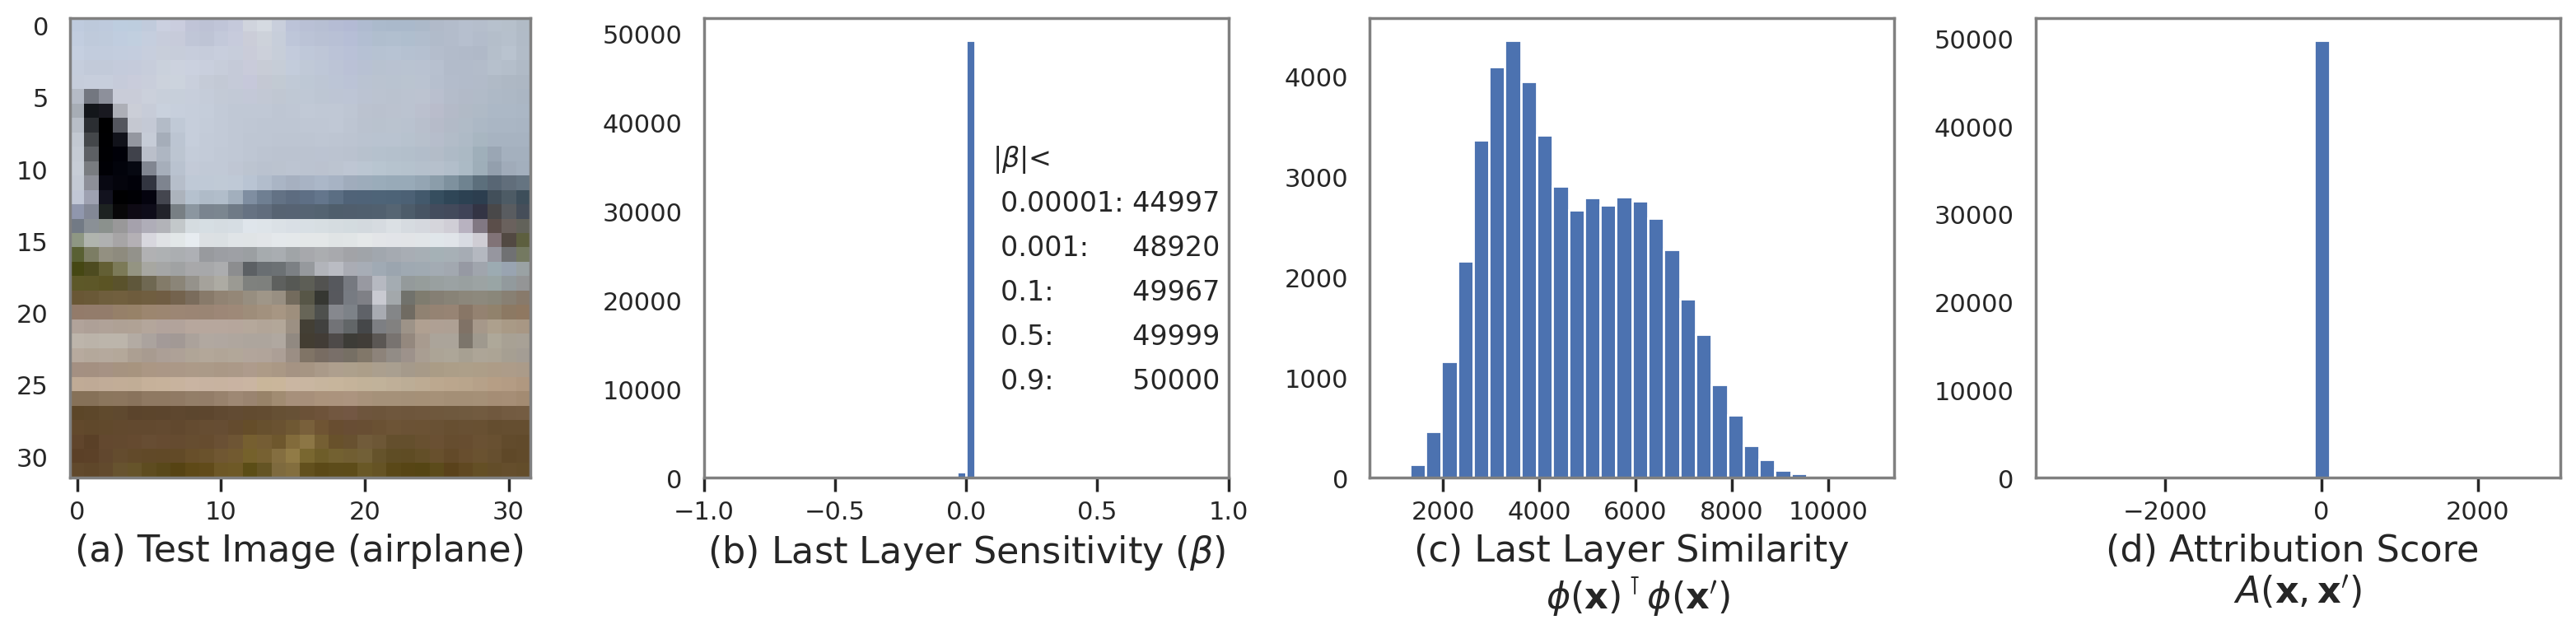

In [25]:
# Illustration of SVE (Fig. A11)
PLOT_HIGH_VAL = False
n_bins = 30
ix_rand = np.random.choice(100, 5, replace=False)
for i in ix_rand:
  print(i)
  x = X_dev[i].copy()
  alpha = alpha_js[i].copy()
  rep_val = representer_vals[i].copy()
  sim_val = sim_vals[i].copy()
  # sim_val = sim_norm_vals[i].copy()

  if PLOT_HIGH_VAL:
    ix_high = np.where(np.abs(alpha) > 0.1)
    alpha = alpha[ix_high]
    rep_val = rep_val[ix_high]
    sim_val = sim_val[ix_high]

  plt.figure(figsize=(16,4))

  plt.subplot(1, 4, 1)
  plt.imshow(x)
  plt.xlabel(f"(a) Test Image ({label_dict[np.squeeze(Y_dev)[i]]})", fontsize=16)

  plt.subplot(1, 4, 2)
  plt.hist(alpha, bins=n_bins)
  # plt.hist(alpha, bins=3)
  abs_alpha = np.abs(alpha)
  plt.xlim((-1,1))
  if not PLOT_HIGH_VAL:
    plt.text(0.1, 35000, r"|$\beta$|<")
    plt.text(0.13, 30000, r"0.00001" + f": {(abs_alpha<0.00001).sum()}")
    plt.text(0.13, 25000, r"0.001" +  f":     {(abs_alpha<0.001).sum()}")
    plt.text(0.13, 20000, r"0.1" + f":         {(abs_alpha<0.1).sum()}")
    plt.text(0.13, 15000, r"0.5" + f":         {(abs_alpha<0.5).sum()}")
    plt.text(0.13, 10000, r"0.9" + f":         {(abs_alpha<0.9).sum()}")
  plt.xlabel(r"(b) Last Layer Sensitivity ($\beta$)", fontsize=16)

  plt.subplot(1, 4, 3)
  plt.hist(sim_val, bins=n_bins)
  plt.xlabel("(c) Last Layer Similarity\n $\phi(\mathbf{x})^\intercal \phi(\mathbf{x'})$", fontsize=16)

  plt.subplot(1, 4, 4)
  plt.hist(rep_val, bins=n_bins)
  abs_rep_val = np.abs(rep_val)
#   plt.text(500, 30000, r"Mean" + f": {str(rep_val.mean())[:5]} $\pm$ {str(rep_val.std())[:5]}")
#   plt.text(500, 25000, r"Min" + f": {min(rep_val)}")
#   plt.text(500, 20000, r"Max" + f": {max(rep_val)}")
  plt.xlabel("(d) Attribution Score \n$A(\mathbf{x}, \mathbf{x'})$", fontsize=16)

  plt.tight_layout()

#   plt.savefig(f"{BASE_DIR}/sm_c10_{i}_inp_alp_sim_rep.pdf")